# 1. 문제정의

## 1.1 경진대회 소개




### 평가
- 평가산식 : MAE(Mean Absolute Error)
- Public 평가 : 전체 Test 데이터 중 무작위 30 % (15일)
- Private 평가 : 전체 Test 데이터 중 나머지 70 % (35일)

### 배경
- 단순한 시계열 추세와 담당자의 직관적 경험에 의존하여한국토지주택공사 구내식당 식수 인원을 예측하였으나,
- 빅데이터 분석으로 얻어지는 보다 정확도 높은 예측을 통해 잔반 발생량을 획기적으로 줄이고자 합니다.

### 데이터 분석 대상
- train : 총 1,025행의 데이터 12열
- test : 총 50행의 데이터 10열("중식계,석식계" 제외)

=> train 데이터를 이용해 모델을 학습 시킨 뒤 test 데이터를 활용해 **"중식계, 석식계"** 예측

## 1.2 평가척도
=> 참가자가 최종적으로 제출한 결과물의 우열을 판단하는 척도

- 본 대회에서는 MAE라는 평가척도를 적용합니다. 이는 MAE에서 A는 absolute, 그러니까 오차의 제곱이 아닌 절대값을 구하는 겁니다. 이 셋은 r2와 같은 상관성 개념이 아니라 거리 개념이라, 0이 제일 정확하고, 값이 커질수록 부정확합니다

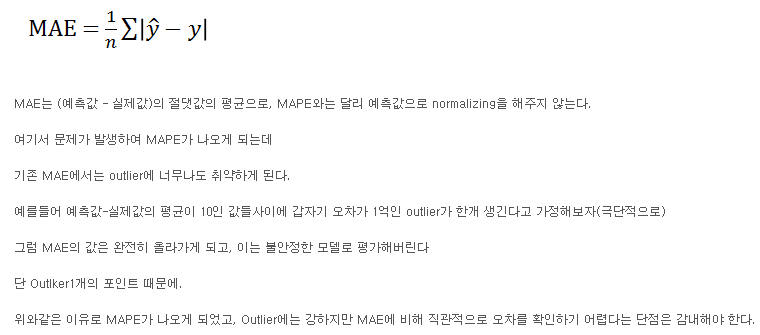
(출처:https://blog.naver.com/limitsinx/221578145366)

=> ***//골고루 좋은 예측을 해야한다//***


## 1.3 도메인 조사

### 용어 : 설명

- 일자 : 년-월-일
- 요일 : 월,화,수,목,금 // 5일 존재
- 본사정원수 : 회사 전체 인원
- 본사휴가자수 : 근무 인원에서 제외
- 본사출장자수 : 근무 인원에서 제외 (하지만 출장자는 오후에 점심먹고 출장을 갈수도?)
- 시간외근무명령서승인건수 : 야간근무 말하는건가?
- 현본사소속재택근무자수 : 근무지로 출근하지않는 인원
- 조식메뉴
- 중식메뉴
- 석식메뉴
- 중식계
- 석식계




## 1.4 문제 해결을 위한 접근 방식

**데이터 탐색 -> 데이터 전처리 -> 모델링 -> 모델링 평가 및 성능 개선 순으로 이루어진다..**


# 2. 탐색적 데이터 분석

정확한 데이터 분석을 위해서는 데이터에 대한 이해가 반드시 선행돼야 한다…… 전반적으로 데이터를 이해하기 위한 데이터 탐색 과정을 탐색적 데이터 분석이라고 합니다.

시각화 설정 및 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#출력 그림 크기 조절
sns.set(rc={'figure.figsize':(12,12)})
plt.style.use('ggplot')
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

#작업 날짜 설정
today = "1116"

## 2.1 학습 데이터

우선 데이터가 가진 정보 파악

### 2.1.1 기초 정보 파악

In [2]:
# 데이터 로드
train = pd.read_csv('data_original/train.csv')
# 데이터 정보 출력
print(train.info())
# 데이터 예시 출력
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB
None


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


## 아이디어 :
    1. 일자 : 데이터타입 날짜형식으로 변경
    2. 요일 : 명목형 타입 -> 숫자형으로 변경 ex) 월 -> 1, 화 -> 2
    3. 출근자 수 : 본사정원 수 - (본사휴가자수 + 본사출장자수 + 현본사 소속재택 근무자 수)
    4. 시간외근무명령서승인건수 : 야근에 영향을 미칠것이고? 석식계에 영향을 주지않을까?
    5. 메뉴 : 밥 / 메인메뉴 / 보조메뉴 / 국 / 음료 -> 이런식으로 전처리 진행해야하지않나?

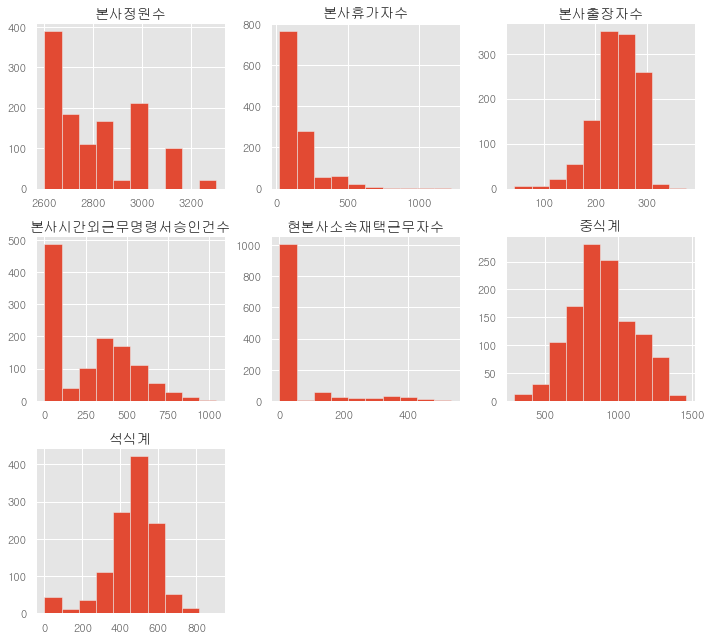

In [3]:
# 학습 데이터 시각화
train.hist(figsize = (10,9))
plt.tight_layout() # 그래프 간격 설정
plt.show()

특이점 :
    중식 인원이 석식 인원보다 적다 당연,,,??

In [4]:
# 추가적인 결측치 개수 파악
pd.DataFrame(train.isna().sum()).T

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,0,0,0,0,0,0,0,0,0,0,0,0


결측이 존재하지 않는다.

In [5]:
# 중복데이터 확인
sum(train.duplicated())

0

In [6]:
# 일자(0) 분포 확인
print(train["일자"].value_counts().head())
print(train["일자"].value_counts().tail())

2016-02-01    1
2019-05-30    1
2019-05-28    1
2019-05-27    1
2019-05-24    1
Name: 일자, dtype: int64
2017-09-14    1
2017-09-13    1
2017-09-12    1
2017-09-11    1
2021-01-26    1
Name: 일자, dtype: int64


In [7]:
# 학습 데이터 기초 통계량 확인
display(train.describe().T)

,count,mean,std,min,25%,50%,75%,max
본사정원수,1205.0,2807.815768,171.264404,2601.0,2645.0,2760.0,2962.0,3305.0
본사휴가자수,1205.0,157.913693,144.190572,23.0,71.0,105.0,185.0,1224.0
본사출장자수,1205.0,241.142739,43.532298,41.0,217.0,245.0,272.0,378.0
본사시간외근무명령서승인건수,1205.0,274.117012,246.239651,0.0,4.0,299.0,452.0,1044.0
현본사소속재택근무자수,1205.0,43.506224,109.937400,0.0,0.0,0.0,0.0,533.0
중식계,1205.0,890.334440,209.505057,296.0,758.0,879.0,1032.0,1459.0
석식계,1205.0,461.772614,139.179202,0.0,406.0,483.0,545.0,905.0


- 휴가자 1200명? 1/3의 인원이 휴가가 가능한가,,??
- 중식 먹는 인원의 수도 생각 보다 적네 max값이 1460가량,,,

Q1. **결측치** : 결측치가 없다.

Q2. **타입변환** : 일자, 요일

=> 일자 : object => **datetime**
=> 요일 : object => **int** 형 변환

Q3. **열이름 변환** : 각열 이름 좀 쉽게 바꾸고 싶다

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
본사정원수,1.000000,0.244666,-0.061688,0.146544,0.452293,-0.115529,-0.173852
본사휴가자수,0.244666,1.000000,-0.273318,-0.230789,0.065397,-0.391975,-0.316894
본사출장자수,-0.061688,-0.273318,1.000000,-0.308757,-0.352643,-0.512680,-0.188164
본사시간외근무명령서승인건수,0.146544,-0.230789,-0.308757,1.000000,0.156792,0.535611,0.571168
현본사소속재택근무자수,0.452293,0.065397,-0.352643,0.156792,1.000000,0.076509,-0.057534
중식계,-0.115529,-0.391975,-0.512680,0.535611,0.076509,1.000000,0.508287
석식계,-0.173852,-0.316894,-0.188164,0.571168,-0.057534,0.508287,1.000000


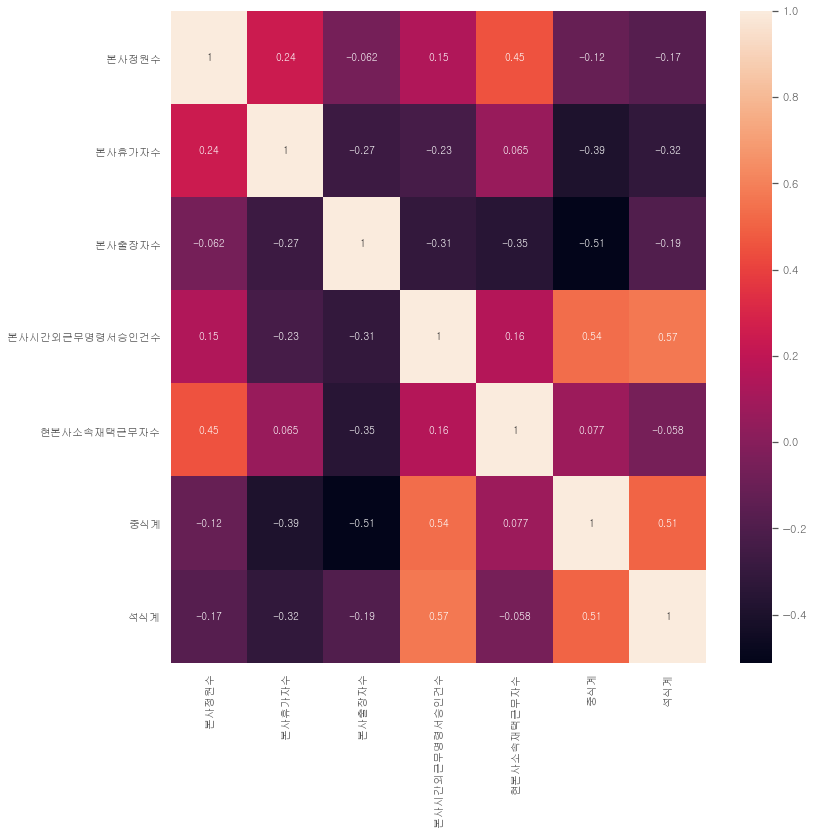

In [8]:
# 반응변수와의 상관성
display(train.corr())

#시각화
sns.heatmap(train.corr(), annot=True)
plt.show()

<AxesSubplot:>

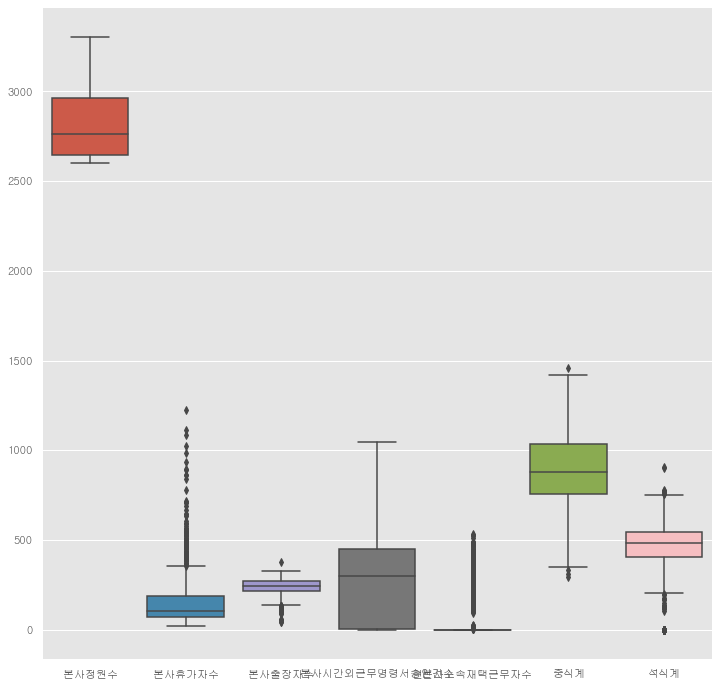

In [9]:
# 분포 시각화
sns.boxplot(data = train)

**Q4. 상관관계** : 아직 뚜렷한 상관관계 파악은 어렵다 -> 전처리가 필요

**Q5. 이상치** : 앞에서 확인했던것과 비슷하게 '본사휴가자 수' 열의 이상치 확인.

In [10]:
## 본사휴가자 수 이상치 열 확인
display(train.loc[train["본사휴가자수"] >= train["본사휴가자수"].quantile(0.75)])

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0
5,2016-02-11,목,2601,383,143,417,0.0,팬케익/찐빵 우유/두유/주스 계란후라이 견과류죽/쌀밥 (쌀:국내산) 감자찌개 ...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 시래기국 훈제오리구이 도토리묵무침 쌈무/양...","참치회덮밥 (쌀,현미흑미:국내산) 맑은국 군만두 과일샐러드 락교 포기김치 (...",1045.0,550.0
6,2016-02-12,금,2601,389,156,93,0.0,모닝롤/야채샌드 우유/두유/주스 계란후라이 고구마죽/쌀밥 (쌀:국내산) 봄동된...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 꽃게탕 돈육굴소스볶음 옥수수전 유채나물 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치콩나물국 미니함박 어묵볶음 물파래무침 ...",909.0,598.0
17,2016-02-29,월,2601,595,168,110,0.0,모닝롤/프렌치토스트 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 콩나물...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 얼갈이된장국 제육볶음 늙은호박전 치커리생채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 버섯들깨탕 꽁치한마리구이 두부양념조림 구이...",869.0,344.0
67,2016-05-13,금,2635,185,268,80,0.0,모닝롤/치즈프레즐 우유/주스 계란후라이 흑임자죽/쌀밥 (쌀:국내산) 아욱국 노...,쌀밥/잡곡밥 (쌀:국내산) 된장찌개 매운돼지갈비찜 해물파전 치커리유자생채 배...,쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국 코다리강정 잡채 얼갈이나물 포기김치 (...,761.0,517.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1186,2020-12-23,수,2990,402,193,5,324.0,모닝롤/호떡맥모닝 우유/주스 계란후라이 흑임자죽/흑미밥 맑은버섯국 연근호두조림 콥샐...,쌀밥/흑미밥/찰현미밥 건새우아욱국 (New)국물쪼리닭 (New)파프리카계란전 마파무...,유부초밥 들깨미역국 페퍼로니치즈피자 골뱅이채소무침&실곤약 콩나물굴소스볶음 포기김치,768.0,354.0
1187,2020-12-24,목,2990,777,160,24,273.0,모닝롤/블루베리사과샌드 우유/주스 계란후라이 누룽지탕/흑미밥 홍합살무국 쪽파숙회 양...,(New)뿌리채소영양밥&달래양념장 호박된장국 오리대패불고기 고등어김치말이찜 파래김 ...,흑미밥 (New)장수제비 해물까스&타르타르D 느타리버섯볶음 치커리귤무침 배추김치,591.0,131.0
1192,2021-01-08,금,2983,255,218,0,373.0,모닝롤/마계토스트 우유/주스 계란후라이/찐계란 영양닭죽/흑미밥 배추된장국 두부동그랑...,쌀밥/흑미밥/찰현미밥 콩나물맑은국 매운소고기낙지볶음 메추리알짜장떡볶이 양배추쌈*쌈장...,흑미밥 감자양파국 돈육김치볶음 팽이버섯채소전 미나리나물무침 깍두기,726.0,250.0
1197,2021-01-15,금,2983,229,222,0,339.0,모닝롤/허니브레드 우유/주스/커피 계란후라이/찐계란 낙지죽/흑미밥 황태국 시래기지짐...,쌀밥/흑미밥/찰현미밥 뼈없는감자탕 고등어구이*와사비장 채소스틱*쌈장 솎음열무나물 석...,흑미밥 순두부백탕 닭볶음탕 비빔만두채소무침 명엽채볶음 포기김치,702.0,277.0


In [11]:
## 본사휴가자 수 이상치 열 확인
display(train.loc[train["본사휴가자수"] >= 1000])

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
310,2017-05-04,목,2637,1224,41,45,0.0,모닝롤/단호박샌드 우유/주스 계란후라이 홍게살죽/쌀밥 (쌀:국내산) 시래기된장국 ...,쌀밥/잡곡밥 (쌀:국내산) 들깨미역국 닭갈비 생선까스*타르소스 무생채 포기김...,야채볶음밥 (쌀:국내산) 유부주머니국 미니버거 야채비빔만두 스틱단무지/오렌지주...,383.0,262.0
709,2018-12-31,월,2846,1085,132,28,0.0,모닝롤/마늘빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 된장찌개 단배추...,쌀밥/잡곡밥 (쌀:국내산) 콩나물국 돈육고추장불고기 (돼지고기:국내산) 감자채볶음...,쌀밥/잡곡밥 (쌀:국내산) 들깨시래기국 훈제오리볶음 계란찜 참나물생채 포기김...,332.0,135.0
864,2019-08-16,금,3305,1026,208,7,0.0,모닝롤/찐빵 우유/주스 계란후라이 해물죽/쌀밥 (쌀:국내산) 근대국 볼어묵볶음 ...,쌀밥/잡곡밥 (쌀:국내산) 닭개장 쇠고기장조림 잡채 비름나물된장무침 포기김치...,쌀밥/잡곡밥 (쌀:국내산) 해물짬뽕국 돈육굴소스볶음 쇠고기두부찜 멸치볶음 열...,466.0,313.0
1038,2020-05-04,월,2962,1113,117,91,189.0,모닝롤/애플파이 우유/주스 계란후라이 누룽지탕/쌀밥 바나나베이비샐러드 소고기무우국...,"쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 버섯들깨국 삼겹살더덕고추장구이 곰취,명이나...","쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 다슬기아욱국 갈릭파닭 돈채호박볶음 짠지오...",504.0,123.0


- 5월 5일 / 1월 1일 / 8월 15일 휴일에 맞추어 황금연휴 계획으로 인한 휴가자 수 증가,,,, 충분히 가능해보인다.

### 2.1.2 연속형 변수

-본사정원수, 본사휴가자수, 본사출장자수, 본사시간외근무명령서승인건수, 현본사소속재택근무자, 중식계.석식계(TARGET)

- 설명변수 10개 중 `5개`

- 반응변수 `2개`

In [12]:
# 수치형 타입의 변수 저장
numerics = [
    'int16','int32','int64','float16','float32','float64'
]
num_cols = train.select_dtypes(include = numerics).columns

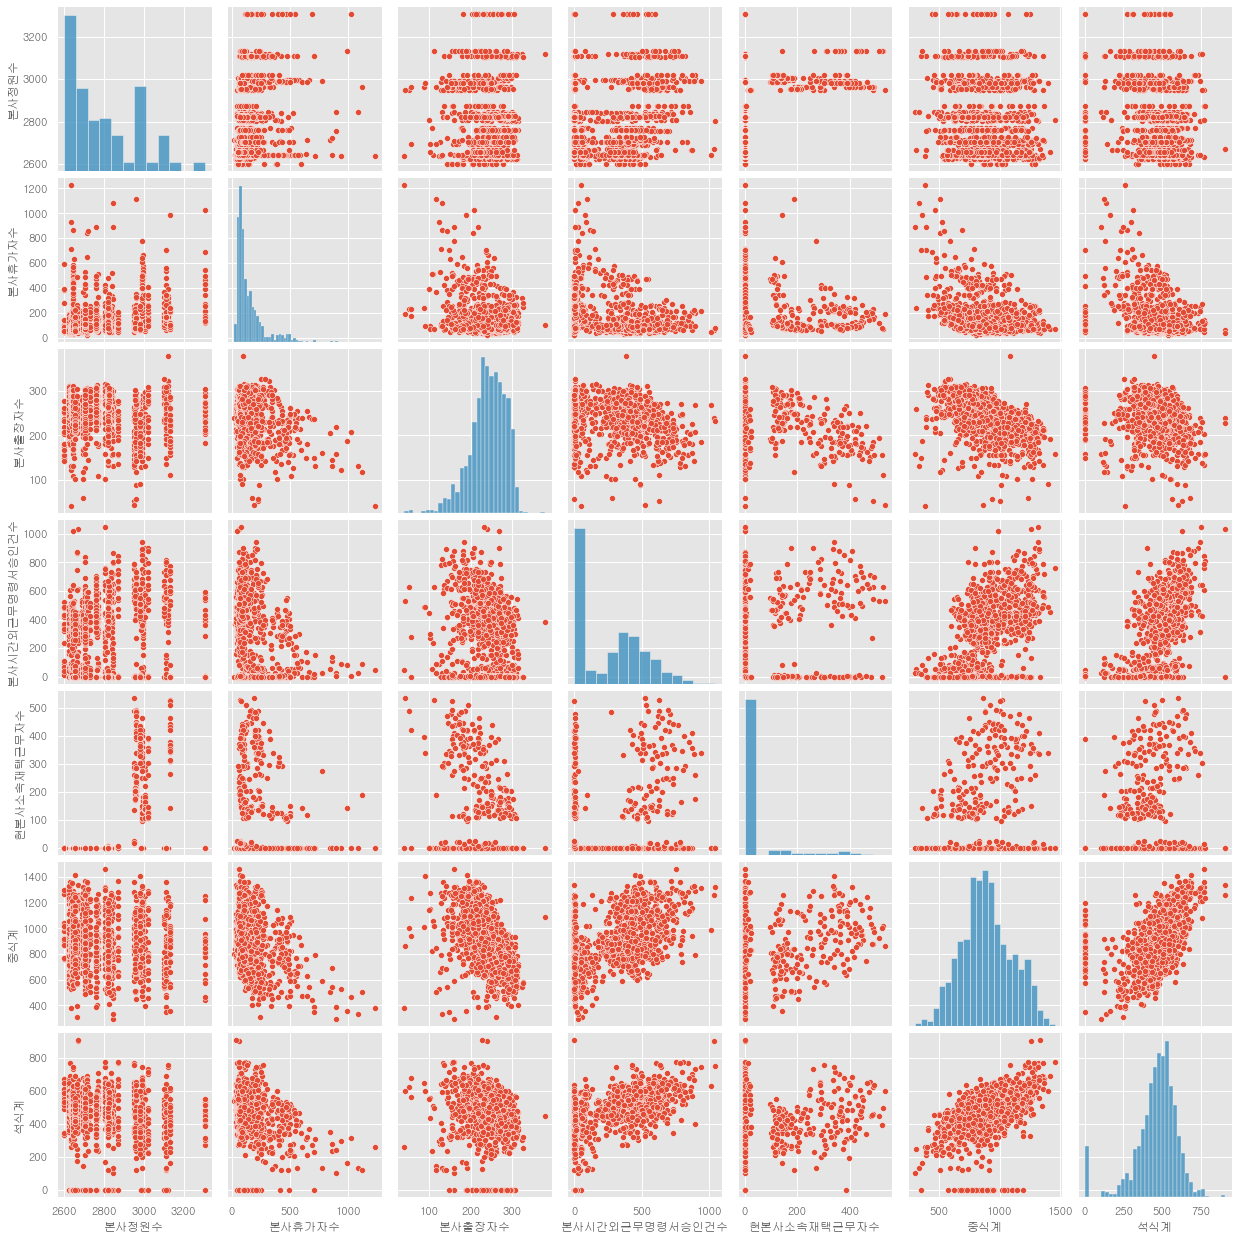

In [13]:
# 상관성 시각화
sns.pairplot(data = train)
plt.show()

**Q6 . 상관성** : 
- 중식 먹는 인원과 석식 먹는 인원이 양의 상관관계
- 본사시간외근무멸령서승인권수도 '중식계','석식계'와 선형성이 보이는 것 같은데

### 분포

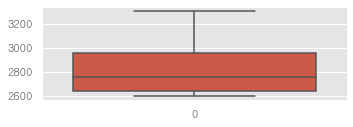

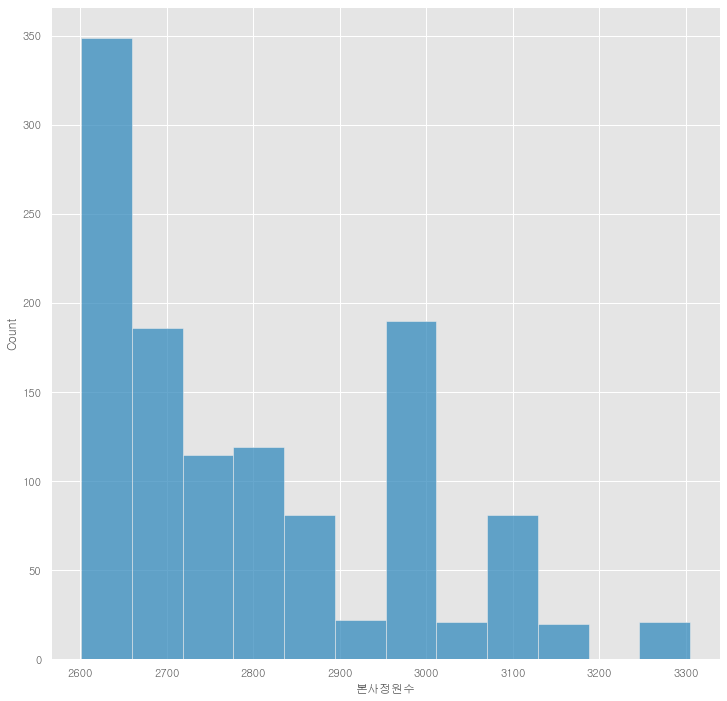

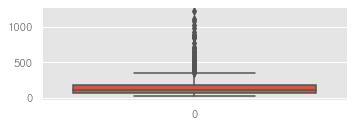

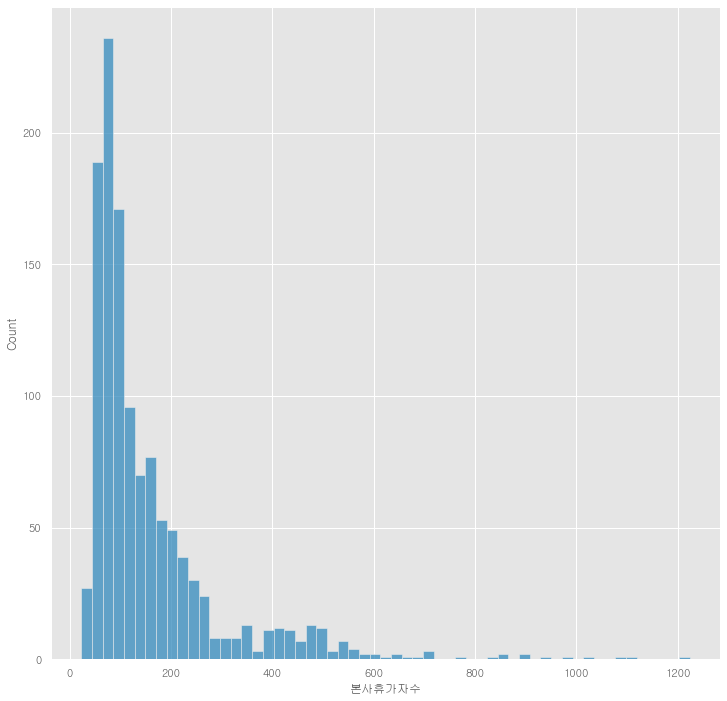

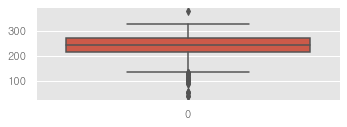

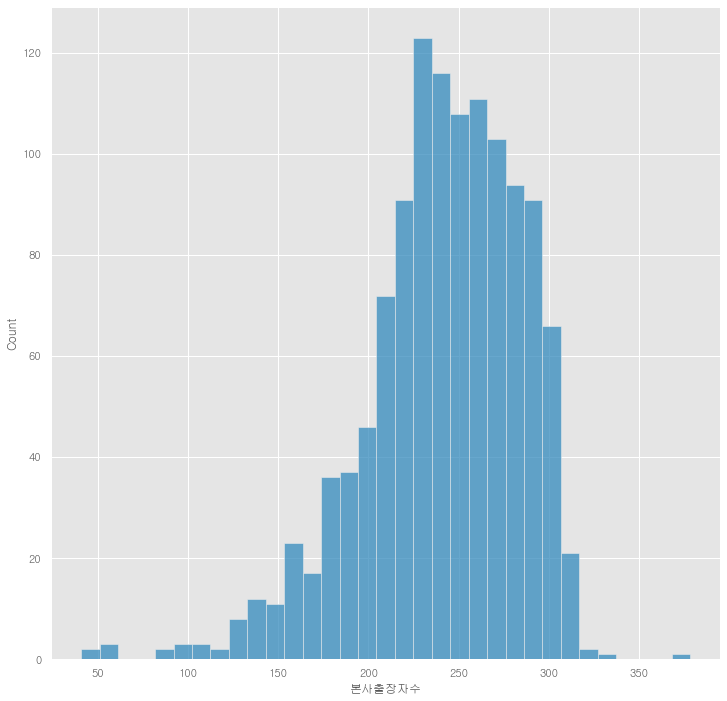

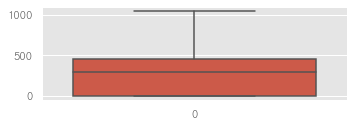

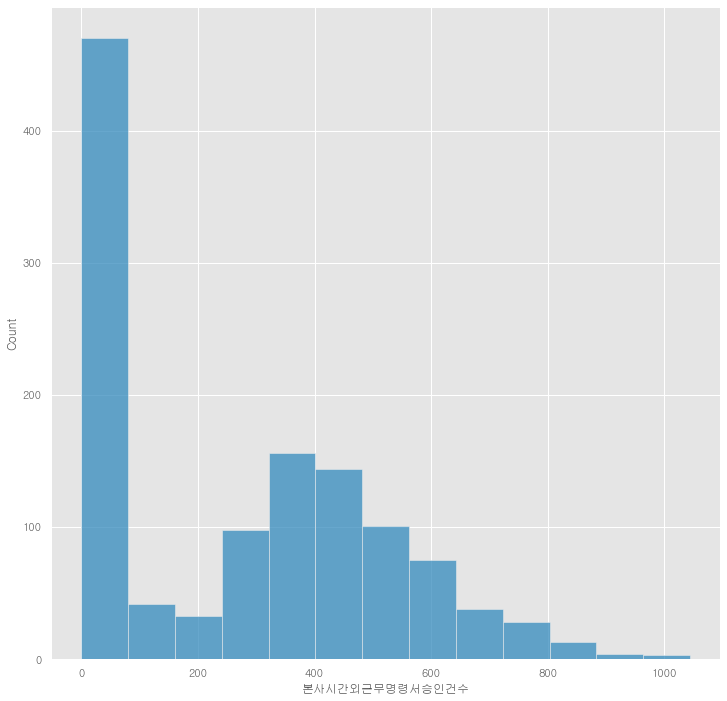

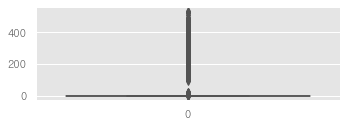

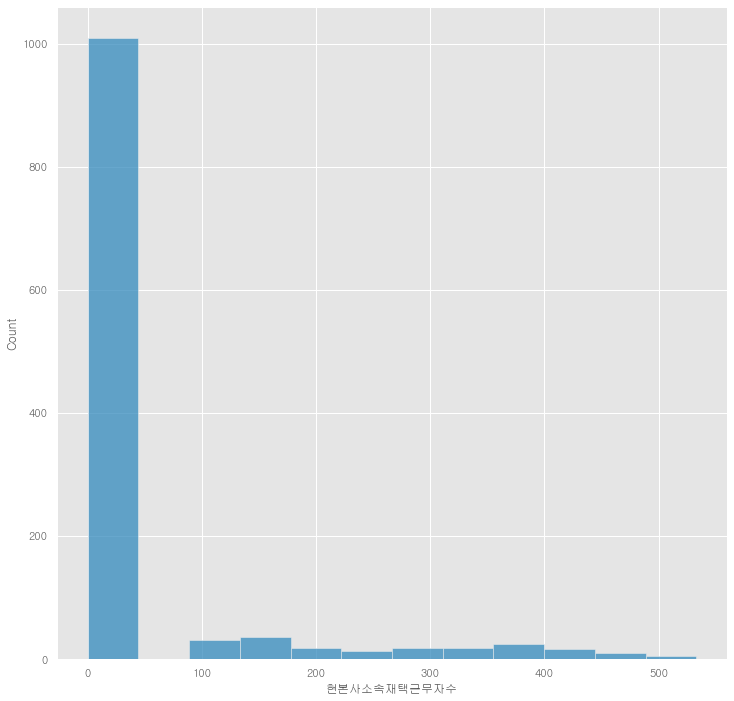

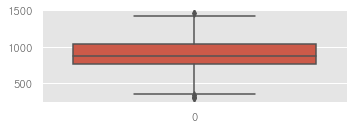

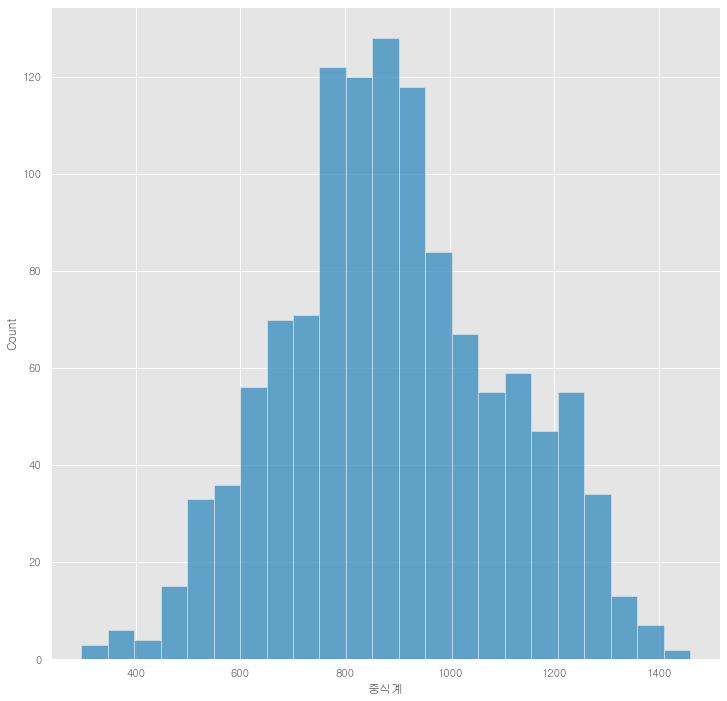

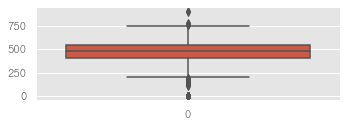

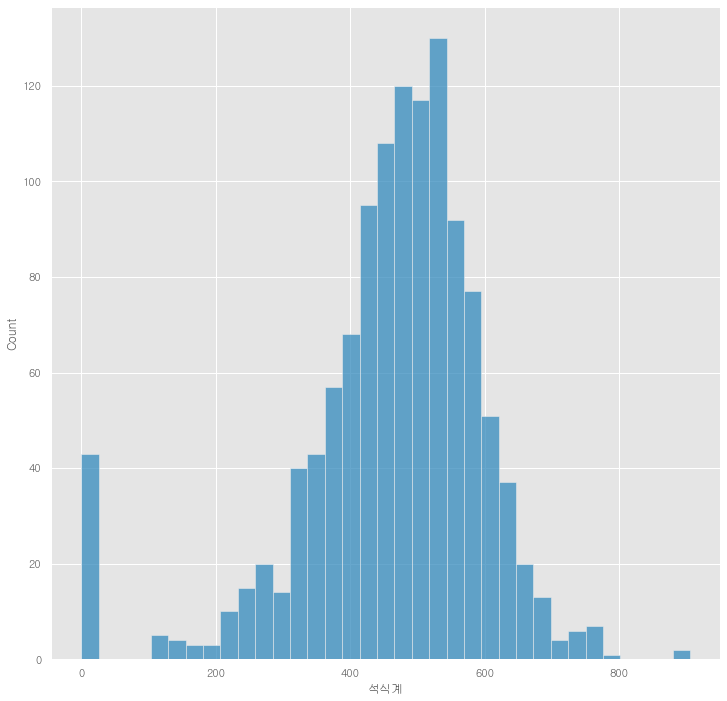

In [14]:
for i,n in enumerate(num_cols):
    plt.subplot(6,2,i+1)
    sns.boxplot(data = train[n])
    plt.show()
    sns.histplot(data = train[n])
    plt.show()

- 석식계가 0인 날이있다 -> 조기퇴근의 날?

In [15]:
#석식계가 0인 날 체크
display(train.loc[train["석식계"] == 0 ])

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
204,2016-11-30,수,2689,68,207,0,0.0,모닝롤/카스텔라 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 고추장찌개 ...,나물비빔밥 (쌀:국내산) 가쯔오장국 치킨핑거*요거트D 감자샐러드 오복지무침 ...,*,1109.0,0.0
224,2016-12-28,수,2705,166,225,0,0.0,모닝롤/고구마파이 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 북어계란국 ...,콩나물밥 (쌀:국내산) 가쯔오장국 미트볼케찹조림 꽃맛살샐러드 군고구마 배추겉...,*,767.0,0.0
244,2017-01-25,수,2697,79,203,0,0.0,모닝롤/토마토샌드 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 ...,카레덮밥 (쌀:국내산) 맑은국 유린기 개성감자만두 오이사과무침 포기김치 (김...,*,720.0,0.0
262,2017-02-22,수,2632,75,252,0,0.0,모닝롤/브라우니 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 꽃게탕 명엽채...,나물비빔밥 (쌀:국내산) 유부장국 생선까스*탈탈소스 파스타샐러드 마늘쫑볶음 ...,*,1065.0,0.0
281,2017-03-22,수,2627,53,235,0,0.0,모닝롤/찐빵 우유/주스 계란후라이 김치죽/쌀밥 (쌀:국내산) 콩나물국 김실파무침...,쌀밥/잡곡밥 (쌀:국내산) 돈육김치찌개 유린기 비엔나볶음 세발나물 깍두기 (...,*,953.0,0.0
306,2017-04-26,수,2626,45,304,0,0.0,모닝롤/와플 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 된장찌개 검정콩조...,비빔밥 (쌀:국내산) 맑은국 오징어튀김 견과류조림 하와이안샐러드 깍두기 (김...,*,835.0,0.0
327,2017-05-31,수,2637,43,265,0,0.0,모닝롤/베이글 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 자...,열무보리비빔밥 (쌀:국내산) 가쯔오장국 탕수만두 콥샐러드 오이지무침 포기김치...,자기계발의날,910.0,0.0
346,2017-06-28,수,2648,58,259,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 쇠고기매운국 고...,콩나물밥 (쌀:국내산) 얼갈이된장국 삼치구이 잡채 아삭고추무침 깍두기 (김치...,*자기계발의날*,745.0,0.0
366,2017-07-26,수,2839,254,246,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 민물새우찌개 숙...,나물비빔밥 미소장국 파스타샐러드 소세지오븐구이 오렌지 포기김치 (김치:국내산),가정의날,797.0,0.0
392,2017-09-01,금,2642,177,303,45,0.0,모닝롤/단팥빵 우유/주스 계란후라이 단호박죽/쌀밥 (쌀:국내산) 대구찌개 깻순나...,쌀밥/잡곡밥 (쌀:국내산) 시래기국 훈제오리구이 두부구이*양념장 쌈무/양파절임...,*,663.0,0.0


In [16]:
# 석식계 0인 날
dinner0 = train.loc[train["석식계"] == 0 ]
dinner0.to_csv("data_preprocess/dinner0_{}.csv".format(today),encoding = "cp949",index = False)

- 2017년 9월달
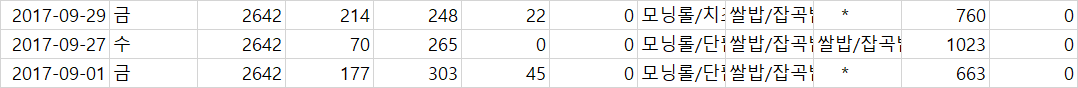
- 2019년 12월 31일 제외하고 모두 매월 마지막주 수요일 **자기계발의 날**! -> 파생변수 생성

In [40]:
# 중식계 0인 날?
train.loc[train["중식계"] == 0 ]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계


### 2.1.2 범주형 변수

- 요일


### Correlation
 -범주형변수 모두 순위가 없는 명목형이므로 spearman 역시 이용하지 않음

목    244
월    241
금    241
화    240
수    239
Name: 요일, dtype: int64

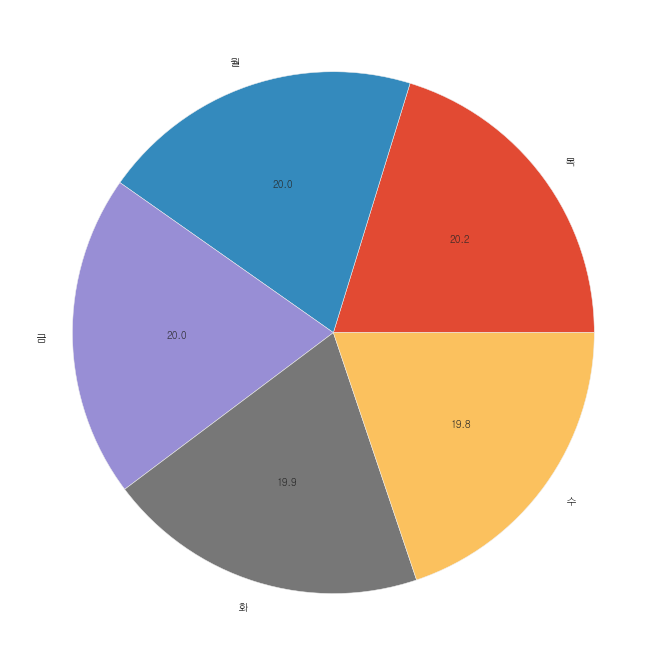

In [17]:
# 자격유형(8) 분포 확인
display(train["요일"].value_counts())
plt.pie(train["요일"].value_counts(),labels = train["요일"].value_counts().index,autopct = "%.1f")
plt.show()

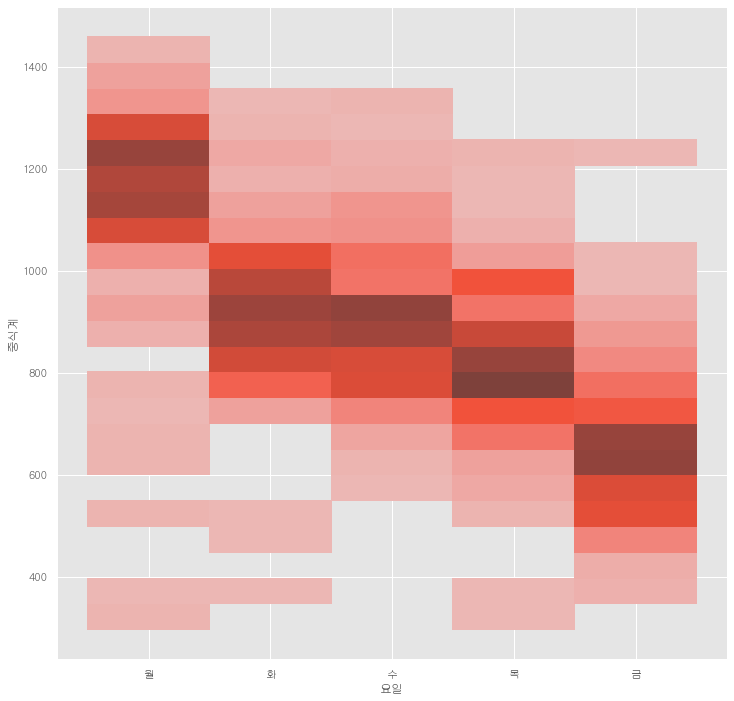

In [18]:
sns.histplot(data = train, x = "요일", y = "중식계")
plt.show()

- 눈에 띄게 주가 지나갈수록 값이 줄어드는 것을 확인 할 수 있다.

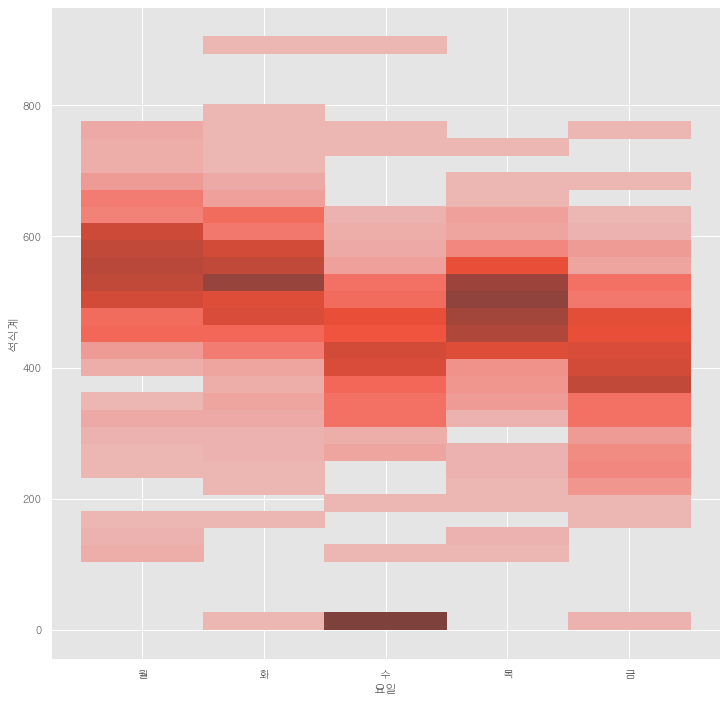

In [19]:
sns.histplot(data = train, x = "요일", y = "석식계")
plt.show()

- 수요일,금요일을 제외하고는 비슷한 모습

In [20]:
#음식 메뉴 보기
train.loc[:,["조식메뉴","중식메뉴","석식메뉴"]]

,조식메뉴,중식메뉴,석식메뉴
0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ..."
1,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무..."
2,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기..."
3,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포..."
4,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:..."
...,...,...,...
1200,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치
1201,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치
1202,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치
1203,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치


In [21]:
train["조식메뉴"]

0       모닝롤/찐빵  우유/두유/주스 계란후라이  호두죽/쌀밥 (쌀:국내산) 된장찌개  쥐...
1       모닝롤/단호박샌드  우유/두유/주스 계란후라이  팥죽/쌀밥 (쌀:국내산) 호박젓국찌...
2       모닝롤/베이글  우유/두유/주스 계란후라이  표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...
3       모닝롤/토마토샌드  우유/두유/주스 계란후라이  닭죽/쌀밥 (쌀,닭:국내산) 근대국...
4       모닝롤/와플  우유/두유/주스 계란후라이  쇠고기죽/쌀밥 (쌀:국내산) 재첩국  방...
                              ...                        
1200    모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...
1201    모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...
1202    모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...
1203    모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...
1204    모닝롤/야채샌드 우유/주스 계란후라이/찐계란 참치죽/흑미밥 홍합탕 애호박새우젓볶음 ...
Name: 조식메뉴, Length: 1205, dtype: object

조식 메뉴
1. 모닝롤/찐빵 선택1
2. 우유 / 두유 / 주스 택 1
3. 계란후라이/찐계란 택 1
4. 죽/쌀밥
5. 된장찌개
6. 반찬
7. 김치

근데 조식 메뉴를 이용해서 중식/석식 메뉴 예측이 가능할까?? 제외하는게 더 나아 보이는데

In [22]:
train.loc[:,"중식메뉴"]

0       쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개  쇠불고기 (쇠고기:호주산) 계란찜 ...
1       쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개  가자미튀김  모둠소세지구이  마늘쫑무...
2       카레덮밥 (쌀,현미흑미:국내산) 팽이장국  치킨핑거 (닭고기:국내산) 쫄면야채무침 ...
3       쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국  주꾸미볶음  부추전  시금치나물  ...
4       쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국  돈육씨앗강정 (돼지고기:국내산) 우엉잡채...
                              ...                        
1200    쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...
1201    쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...
1202    전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...
1203    쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...
1204    쌀밥/귀리밥/찰현미밥 들깨미역국 교촌간장치킨 옥수수콘치즈구이 가지고추장무침 포기김치...
Name: 중식메뉴, Length: 1205, dtype: object

In [23]:
train.loc[1201,"중식메뉴"]

'쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐러드*파인D '

중식메뉴
1. 밥
2. 국
3. 반찬1
4. 반찬2
5. 반찬3
6. 김치

가끔 김치와 샐러드의 위치가 바뀔때가 있다.

In [24]:
train.loc[:,"석식메뉴"]

0       쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장  자반고등어구이  두부조림  건파래무침 ...
1       콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국  유산슬 (쇠고기:호주산) 아삭고추무...
2       쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개  황태양념구이 (황태:러시아산) 고기...
3       미니김밥*겨자장 (쌀,현미흑미:국내산) 우동  멕시칸샐러드  군고구마  무피클  포...
4       쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...
                              ...                        
1200       김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치 
1201              흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치 
1202          흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치 
1203              흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치 
1204           (New)할라피뇨멸치주먹밥 잔치국수 수제고기육전 쑥갓나물 양파초절임 깍두기 
Name: 석식메뉴, Length: 1205, dtype: object

석식 메뉴
1. 밥
2. 국
3. 반찬1
4. 반찬2
5. 반찬3
6. 김치

가끔 김치와 샐러드의 위치가 바뀔때가 있다.

## 2.2 테스트 데이터

우선 데이터가 가진 정보 파악

### 2.2.1 기초 정보 파악

In [25]:
# 데이터 로드
test = pd.read_csv('data_original/test.csv')
# 데이터 정보 출력
print(test.info())
# 데이터 예시 출력
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              50 non-null     object 
 1   요일              50 non-null     object 
 2   본사정원수           50 non-null     int64  
 3   본사휴가자수          50 non-null     int64  
 4   본사출장자수          50 non-null     int64  
 5   본사시간외근무명령서승인건수  50 non-null     int64  
 6   현본사소속재택근무자수     50 non-null     float64
 7   조식메뉴            50 non-null     object 
 8   중식메뉴            50 non-null     object 
 9   석식메뉴            50 non-null     object 
dtypes: float64(1), int64(4), object(5)
memory usage: 4.0+ KB
None


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021-01-29,금,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치
3,2021-02-01,월,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치
4,2021-02-02,화,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치


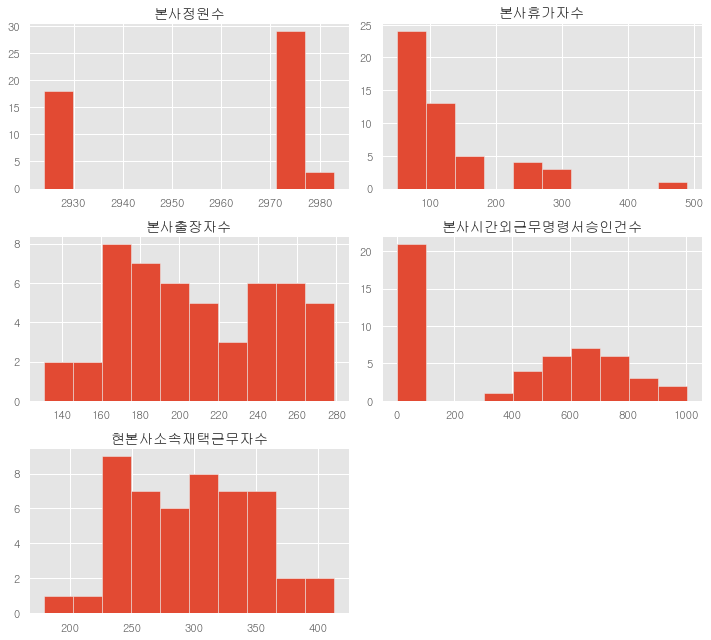

In [26]:
# 학습 데이터 시각화
test.hist(figsize = (10,9))
plt.tight_layout() # 그래프 간격 설정
plt.show()

특이점 :
    중식 인원이 석식 인원보다 적다 당연,,,??

In [27]:
# 추가적인 결측치 개수 파악
pd.DataFrame(test.isna().sum()).T

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,0,0,0,0,0,0,0,0,0,0


결측이 존재하지 않는다.

In [28]:
# 중복데이터 확인
sum(test.duplicated())

0

In [29]:
# 일자(0) 중복, 유니크 확인
print(test["일자"].value_counts().head())
print(test["일자"].value_counts().tail())

2021-01-27    1
2021-03-24    1
2021-03-10    1
2021-03-11    1
2021-03-12    1
Name: 일자, dtype: int64
2021-02-25    1
2021-02-26    1
2021-03-02    1
2021-03-03    1
2021-04-09    1
Name: 일자, dtype: int64


In [30]:
# 학습 데이터 기초 통계량 확인
display(test.describe().T)

,count,mean,std,min,25%,50%,75%,max
본사정원수,50.0,2956.84,24.968846,2924.0,2924.00,2974.0,2975.00,2983.0
본사휴가자수,50.0,129.52,84.065873,50.0,78.25,95.0,137.50,489.0
본사출장자수,50.0,209.22,39.454593,131.0,176.50,202.5,245.25,279.0
본사시간외근무명령서승인건수,50.0,380.14,346.564304,0.0,1.00,465.5,681.00,1003.0
현본사소속재택근무자수,50.0,298.14,52.058056,179.0,257.25,300.0,333.25,413.0


Q1. **결측치** : 결측치가 없다.

Q2. **타입변환** : 일자, 요일

=> 일자 : object => **datetime**
=> 요일 : object => **int** 형 변환

Q3. **열이름 변환** : 각열 이름 좀 쉽게 바꾸고 싶다

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수
본사정원수,1.000000,0.007576,0.111323,-0.042708,0.105871
본사휴가자수,0.007576,1.000000,0.222882,-0.411078,-0.488268
본사출장자수,0.111323,0.222882,1.000000,-0.502934,-0.488159
본사시간외근무명령서승인건수,-0.042708,-0.411078,-0.502934,1.000000,0.286351
현본사소속재택근무자수,0.105871,-0.488268,-0.488159,0.286351,1.000000


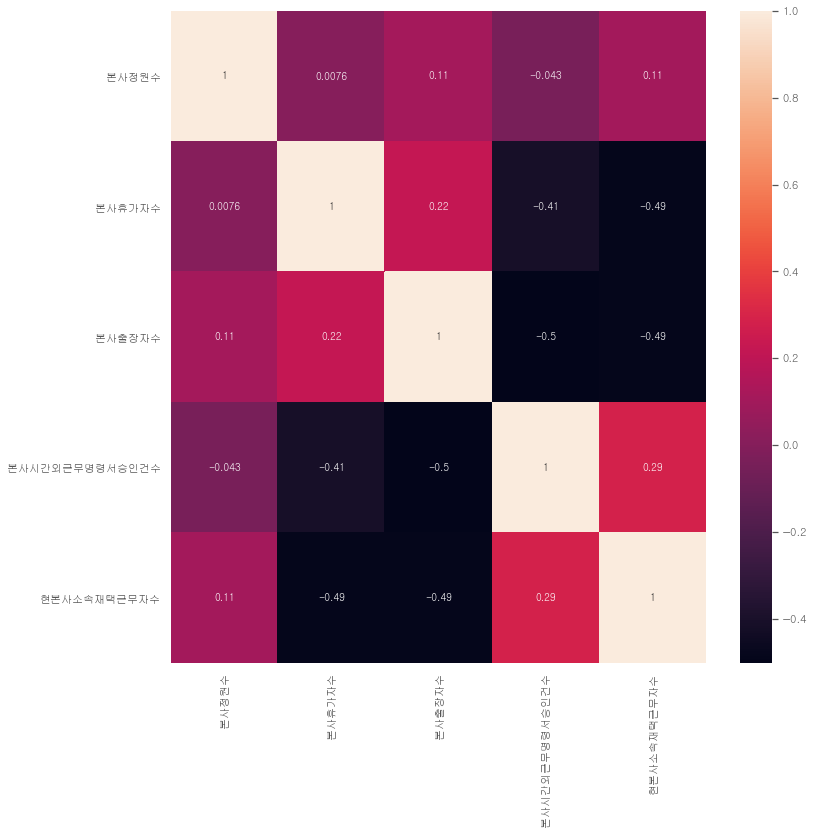

In [31]:
# 반응변수와의 상관성
display(test.corr())

#시각화
sns.heatmap(test.corr(), annot=True)
plt.show()

<AxesSubplot:>

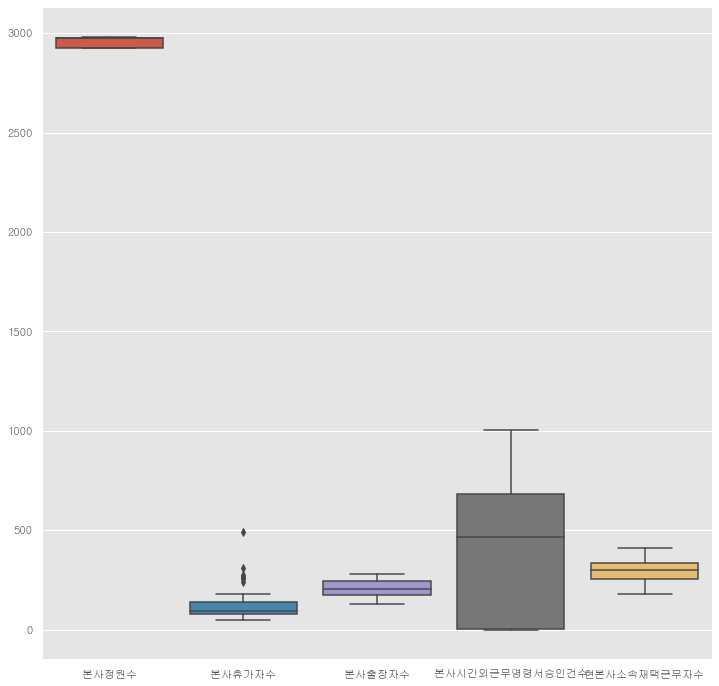

In [32]:
# 분포 시각화
sns.boxplot(data = test)

**Q4. 상관관계** : 아직 뚜렷한 상관관계 파악은 어렵다 -> 전처리가 필요

**Q5. 이상치** : 특이점이 없다.

### 2.1.2 연속형 변수

-본사정원수, 본사휴가자수, 본사출장자수, 본사시간외근무명령서승인건수, 현본사소속재택근무자, 중식계.석식계(TARGET)

- 설명변수 10개 중 `5개`

- 반응변수 `2개`

In [33]:
# 수치형 타입의 변수 저장
numerics = [
    'int16','int32','int64','float16','float32','float64'
]
num_cols = test.select_dtypes(include = numerics).columns

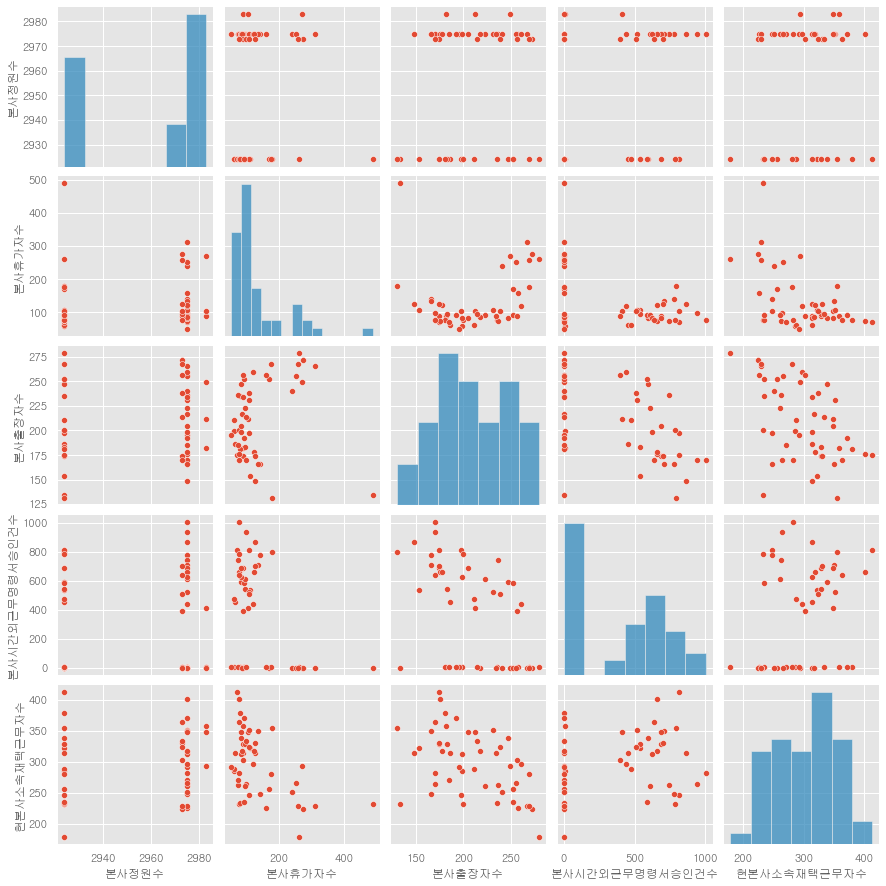

In [34]:
# 상관성 시각화
sns.pairplot(data = test)
plt.show()

### 분포

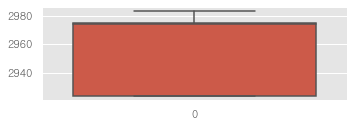

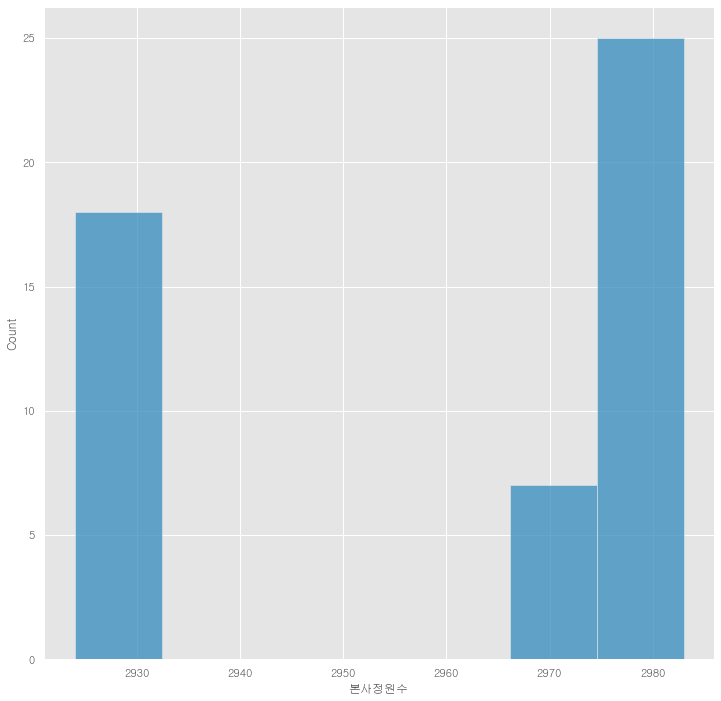

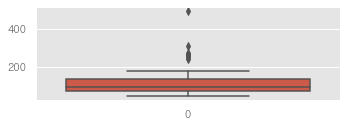

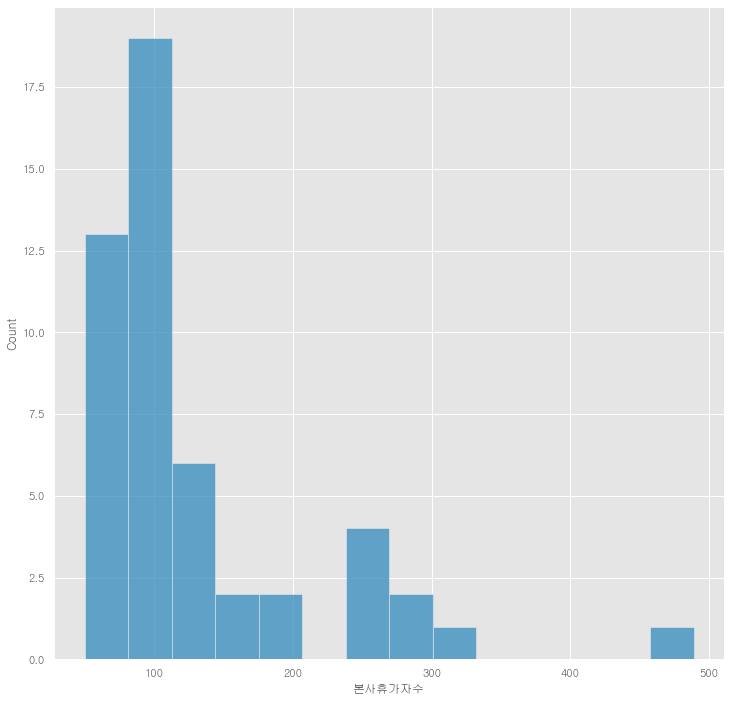

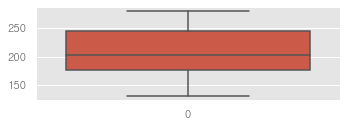

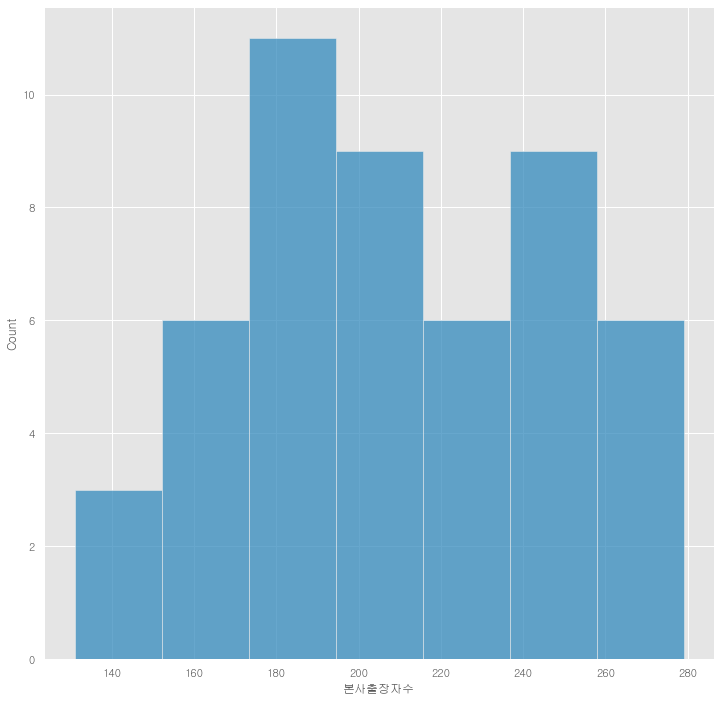

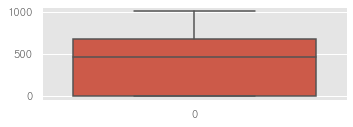

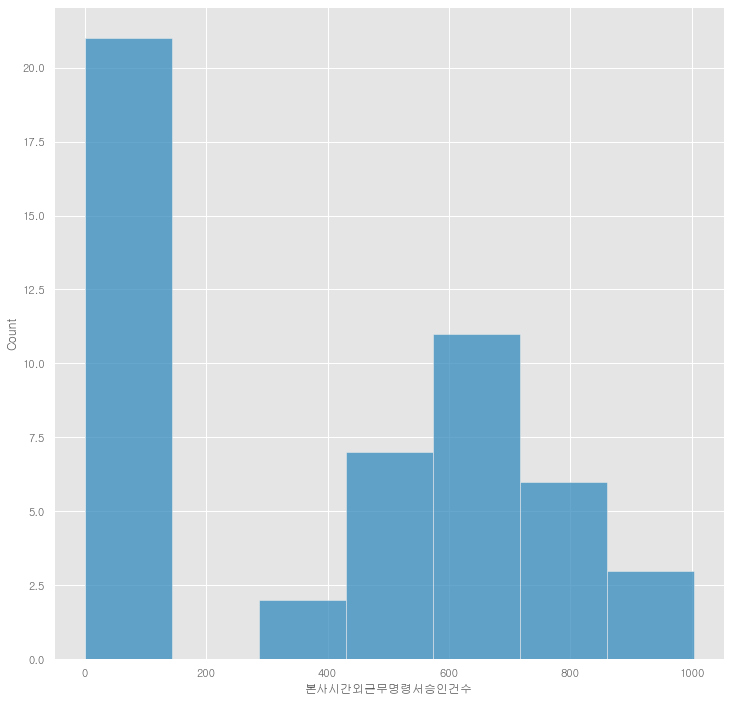

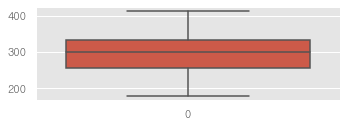

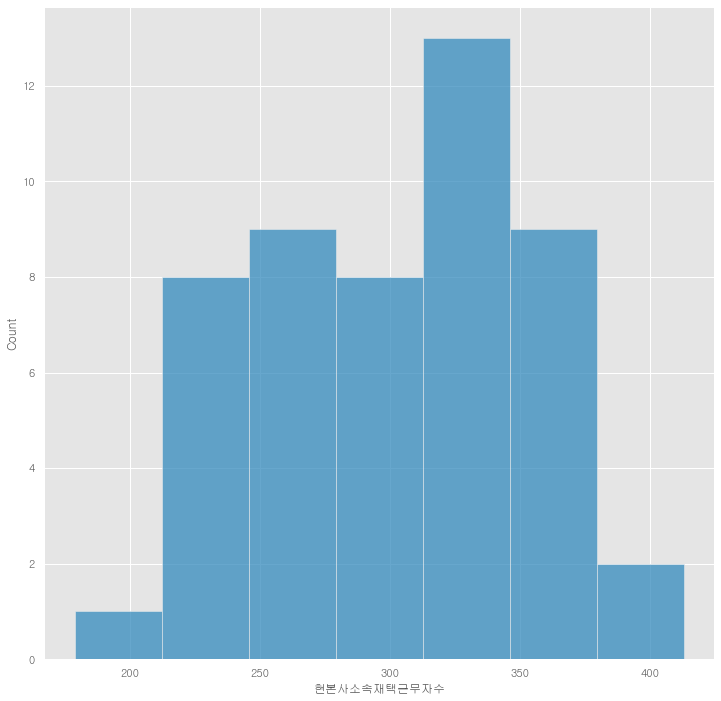

In [35]:
for i,n in enumerate(num_cols):
    plt.subplot(6,2,i+1)
    sns.boxplot(data = test[n])
    plt.show()
    sns.histplot(data = test[n])
    plt.show()

### 2.1.2 범주형 변수

- 요일


### Correlation
 -범주형변수 모두 순위가 없는 명목형이므로 spearman 역시 이용하지 않음

수    11
목    10
금    10
화    10
월     9
Name: 요일, dtype: int64

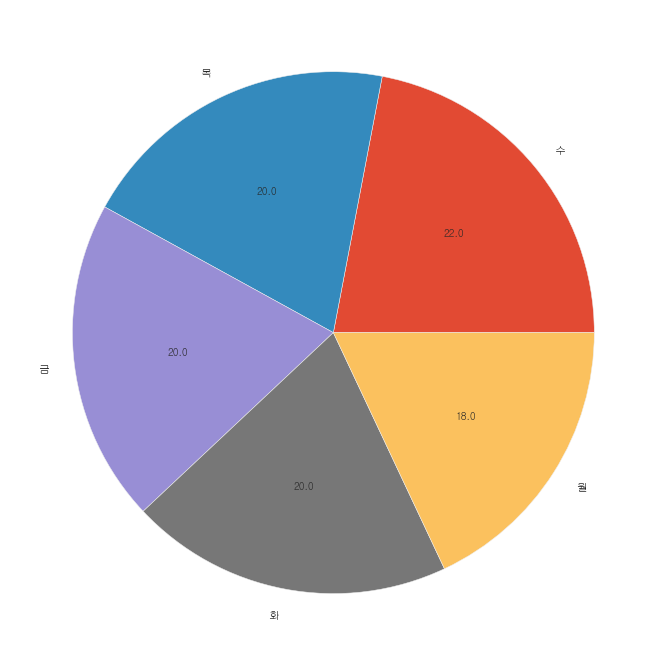

In [36]:
# 자격유형(8) 분포 확인
display(test["요일"].value_counts())
plt.pie(test["요일"].value_counts(),labels = test["요일"].value_counts().index,autopct = "%.1f")
plt.show()

In [37]:
test["조식메뉴"]

0     모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...
1     모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...
2     모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...
3     모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...
4     모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...
5     모닝롤/게살모닝샌드 우유/주스 계란후라이/찐계란 소고기죽/흑미밥 시래기된장국 베이컨...
6     모닝롤/사과파이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 아욱국 새송이버섯곤약장...
7     모닝롤/앙버터모닝빵 우유/주스 계란후라이/찐계란 고구마죽/흑미밥 옹심이국 머위나물무...
8     모닝롤/스콘 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 꽃게탕 근대나물무침 연두부...
9     모닝롤/치즈팡샌드 우유/주스 계란후라이/찐계란 팥죽/흑미밥 맑은버섯국 시금치나물무침...
10    모닝롤/길거리토스트 우유/주스 계란후라이/찐계란 옥수수스프/흑미밥 우거지국 스팸구이...
11    모닝롤/파운드케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 열무된장국 분홍소세지...
12    모닝롤/모닝샌드 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 대구매운탕 가지나물 양...
13    모닝롤/트위스터버거 우유/주스 계란후라이/찐계란 단호박크림스프/흑미밥 사골파국 양념...
14    모닝롤/허니브레드 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 봄동된장국 참치채소볶...
15    모닝롤/크로와상샌드위치 우유/주스 계란후라이/찐계란 쇠고기죽/흑미밥 닭살해장국 해물...
16    모닝롤/흑미쌀찐빵 우유/주스 계란후라이 누룽지탕/흑미밥 미역국 매콤부들어묵볶음 양상...
17    모닝롤/프렌치토스트 우유/주스 계란후라이 녹두죽/흑미밥 북어해장국 부추김무침

조식 메뉴
1. 모닝롤/찐빵 선택1
2. 우유 / 두유 / 주스 택 1
3. 계란후라이/찐계란 택 1
4. 죽/쌀밥
5. 된장찌개
6. 반찬
7. 김치

근데 조식 메뉴를 이용해서 중식/석식 메뉴 예측이 가능할까?? 제외하는게 더 나아 보이는데

In [38]:
test.loc[:,"중식메뉴"]

0     쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...
1     쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...
2     쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...
3     쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...
4     쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...
5      쌀밥/흑미밥/찰현미밥 아욱국 매콤해물볶음 감자조림 미나리나물 포기김치 콥샐러드*렌치D 
6     쌀밥/차조밥/찰현미밥 설렁탕 고등어김치말이찜 볼어묵굴소스볶음 브로콜리숙회*초장 석박...
7     쌀밥/흑미밥/찰현미밥 북엇국 닭볶음탕 채소전*장 솎음열무나물무침 포기김치 양상추샐러...
8     쌀밥/흑미밥/찰현미밥 감자양파국 돈수육*씨앗쌈장 매콤어묵볶음 콩나물파채무침 포기김치...
9     쌀밥/기장밥/찰현미밥 장각백숙 적어양념장구이 채소스틱*쌈장 도라지오이초무침 겉절이김...
10    유니짜장밥 짬뽕국 수제찹쌀꿔바로우 계란후라이 단무지락교무침 포기김치 그린샐러드*딸기...
11    쌀밥/흑미밥/찰현미밥 떡국 소갈비찜 한식잡채 참나물겉절이 포기김치 양상추샐러드*블루...
12    쌀밥/수수밥/찰현미밥 육개장 닭살겨자냉채 오이스틱*쌈장 탕평채 깍두기/수박 양상추샐...
13    쌀밥/흑미밥/찰현미밥 미니쌀국수 삼겹살고추장구이 스프링롤*타르타르D 동초나물무침 알...
14    쌀밥/완두콩밥/찰현미밥 김치어묵탕 수원왕갈비통닭 두부양념조림 연근깨소스무침 포기김치...
15    쌀밥/흑미밥/찰현미밥 유부장국 해물누룽지탕 김치전 마약계란장조림 포기김치 양상추샐러...
16    쌀밥/흑미밥/찰현미밥 호박고추장찌개 안동찜닭 마카로니치즈범벅 세발나물무침 포기김치/...
17      쌀밥/보리밥/찰현미밥 근대국 등갈비김치찜 감자채전*장 치커리무침 깍두기 

중식메뉴
1. 밥
2. 국
3. 반찬1
4. 반찬2
5. 반찬3
6. 김치

가끔 김치와 샐러드의 위치가 바뀔때가 있다.
(new) 붙어있는거 관심끌수있지않을까?

In [39]:
test.loc[:,"석식메뉴"]

0         흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치 
1                   충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지 
2                   흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치 
3                  흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치 
4              흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치 
5          오므라이스 가쓰오장국 빌소세지구이*구운채소 단감치커리무침 양념고추지 겉절이김치 
6            흑미밥 계란파국 돈육두루치기 감자채파프리카볶음 세발나물오리엔탈무침 포기김치 
7              유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이 포기김치 
8                        흑미밥 냉이국 반반치킨 꼬막채소무침 청경채찜 포기김치 
9                   흑미밥 미역국 매운소불고기 단호박두부탕수 메추리알장조림 석박지 
10              흑미밥 참치김치찌개 오징어굴소스볶음 차돌비빔국수 건새우무나물 포기김치 
11                  흑미밥 순두부백탕 수제치킨까스 쫄면채소무침 얼갈이나물 포기김치 
12                   흑미밥 손수제비국 쇠고기낙지볶음 카레홍합찜 쑥갓나물 포기김치 
13                곤드레밥 황태국 찰떡떡갈비조림 계란후라이 재래김*달래양념장 무생채 
14              흑미밥 바지락된장찌개 제육볶음 양배추숙*쌈장 노가리고추조림 겉절이김치 
15              흑미밥 버섯들깨탕 아귀콩나물찜 콤비네이션피자 돌나물&된장소스 포기김치 
16                        흑미밥 동태알탕 깐풍육 고사리볶음 오이무침 포기김치 
17                 흑미밥 쇠고기무국 춘전닭갈비 뉴욕핫도그 유채나물된장무

석식 메뉴
1. 밥
2. 국
3. 반찬1
4. 반찬2
5. 반찬3
6. 김치

가끔 김치와 샐러드의 위치가 바뀔때가 있다.

## 전처리 아이디어 :
    1. 일자 : 데이터타입 날짜형식으로 변경
    2. 요일 : 명목형 타입 -> 숫자형으로 변경 ex) 월 -> 1, 화 -> 2
    3. 출근자 수 : 본사정원 수 - (본사휴가자수 + 본사출장자수 + 현본사 소속재택 근무자 수)
    4. 시간외근무명령서승인건수 : 야근에 영향을 미칠것이고? 석식계에 영향을 주지않을까?
    5. 메뉴 : 밥 / 메인메뉴 / 보조메뉴 / 국 / 음료 -> 이런식으로 전처리 진행해야하지않나? -> 띄어쓰기로 전처리 진행하면 좋을거 같다. -> 자기계발의 날도 제외? 근데 이러면,,,?? 중식 날짜도 문제가 될 거 같다.

## 코드 참고후 추가적인 아이디어


1. 월별로 특이점이 있지않을까? -> 예를 들어 연말,연초에는 회식이나 약속등이 많을수도?
2. 메뉴를 굳이 다 나누지 말고 3가지만으로 (밥,국,메인반찬) -> 그래도 양이 너무 많은데...
3. 이상치를 다시 한 번 생각해 봐야 할 거 같다.